In a rare-event problem, we have an unbalanced dataset. Meaning, we have fewer positively labeled samples than negative. In a typical rare-event problem, the positively labeled data are around 5–10% of the total. In an extreme rare event problem, we have less than 1% positively labeled data.

We can always go with a Machine Learning approach. To make it work, we can undersample from negatively labeled data to have a close to a balanced dataset. Since we have about 0.6% positively labeled data, the undersampling will result in rougly a dataset that is about 1% of the size of the original data. A Machine Learning approach, e.g. SVM or Random Forest, will still work on a dataset of this size. However, it will have limitations in its accuracy. And we will not utilize the information present in the remaining ~99% of the data.

# Autoencoder for Classification

The autoencoder approach for classification is similar to anomaly detection. In anomaly detection, we learn the pattern of a normal process. Anything that does not follow this pattern is classified as an anomaly. For a binary classification of rare events, we can use a similar approach using autoencoders

# How to use an Autoencoder rare-event classification?

   1. We will divide the data into two parts: positively labeled and negatively labeled.
   2. The negatively labeled data is treated as normal state of the process. A normal state is when the process is eventless.
   3. We will ignore the positively labeled data, and train an Autoencoder on only negatively labeled data.
   4. This Autoencoder has now learned the features of the normal process.
   5. A well-trained Autoencoder will predict any new data that is coming from the normal state of the process (as it will have the same pattern or distribution).
   6. Therefore, the reconstruction error will be small.
   7. However, if we try to reconstruct a data from a rare-event, the Autoencoder will struggle.
   8. This will make the reconstruction error high during the rare-event.
   9. We can catch such high reconstruction errors and label them as a rare-event prediction.
   10. This procedure is similar to anomaly detection methods.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [45]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,fe,time_series,visual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv(r"E:\gitlab\machine-learning\dataset\processminer-rare-event-mts - data.csv")

In [4]:
df

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,5/28/99 23:58,0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,0
18394,5/29/99 0:00,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915699,0.010620,0.175348,-0.011235,0
18395,5/29/99 0:02,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,0
18396,5/29/99 0:04,0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,0


The objective of this rare-event problem is to predict a sheet-break before it occurs. We will try to predict the break 4 minutes in advance. To build this model, we will shift the labels 2 rows up (which corresponds to 4 minutes). We can do this as df.y=df.y.shift(-2). However, in this problem we would want to do the shifting as: if row n is positively labeled,

In [5]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


In [9]:
# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = time_series.curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))

After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


we moved the positive label at 5/1/99 8:38 to t-1 and t-2 timestamps, and dropped row t. There is a time difference of more than 2 minutes between a break row and the next row because in the data consecutive break rows are deleted. This was done to prevent a classification model learn predicting a break after the break has happened.

In [10]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [11]:
df

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0.0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,...,29.984624,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242
18394,0.0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,...,29.984624,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915699,0.010620,0.175348,-0.011235
18395,0.0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,...,29.984624,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228
18396,0.0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,...,29.984624,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221


# Prepare data for LSTM models

LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). Samples mean the number of data points. Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [12]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In [13]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the temporalize function with lookback=5. For the modeling, we may use a longer lookback.

In [14]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
252,0.0,0.987078,-4.025989,-1.210205,0.899603,0.450338,14.098854,0.000732,-0.051043,-0.059966,...,29.984624,11.248703,-0.752385,-5.014893,-67.454037,66.232568,4.114269,0.033726,4.845087,0.007776
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


In [16]:
lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = time_series.temporalize(X = input_X, y = input_y, lookback = lookback)

In [17]:
print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))

For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,0.001791,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
1,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,0.001791,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
2,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
3,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
4,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


# Divide the data into train, valid, and test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [20]:
X_train.shape

(11691, 5, 1, 59)

In [21]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [22]:
X_train_y0.shape

(11536, 5, 1, 59)

# Reshaping the data

The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [23]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

# Standardize the data

It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature.

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this, we will require two UDFs.

   1. flatten: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of temporalize, meaning X = flatten(temporalize(X)).
   2. scale: This function will scale a 3D array that we created as inputs to the LSTM.

In [26]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(time_series.flatten(X_train_y0))

In [27]:
X_train_y0_scaled = time_series.scale(X_train_y0, scaler)
X_train_y1_scaled = time_series.scale(X_train_y1, scaler)
X_train_scaled = time_series.scale(X_train, scaler)

In [29]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = time_series.flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.
  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.
  0. -0. -0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [31]:
X_valid_scaled = time_series.scale(X_valid, scaler)
X_valid_y0_scaled = time_series.scale(X_valid_y0, scaler)

X_test_scaled = time_series.scale(X_test, scaler)

# LSTM Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [32]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001

In [55]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 32)             11776     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
__________________________________________________

As a rule-of-thumb, look at the number of parameters. If not using any regularization, keep this less than the number of samples. If using regularization, depending on the degree of regularization you can let more parameters in the model that is greater than the sample size. For example, if using dropout with 0.5, you can have up to double the sample size (loosely speaking).

In [56]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam,metrics=['accuracy'])

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=1)

Train on 11536 samples, validate on 2880 samples
Epoch 1/200
11536/11536 [==============================] - 7s 586us/sample - loss: 0.9890 - accuracy: 0.0200 - val_loss: 0.9957 - val_accuracy: 0.0183
Epoch 2/200
11536/11536 [==============================] - 4s 346us/sample - loss: 0.9075 - accuracy: 0.0343 - val_loss: 0.8669 - val_accuracy: 0.0499
Epoch 3/200
11536/11536 [==============================] - 4s 351us/sample - loss: 0.7883 - accuracy: 0.0670 - val_loss: 0.7466 - val_accuracy: 0.0763
Epoch 4/200
11536/11536 [==============================] - 4s 340us/sample - loss: 0.6789 - accuracy: 0.1039 - val_loss: 0.6341 - val_accuracy: 0.1299
Epoch 5/200
11536/11536 [==============================] - 4s 348us/sample - loss: 0.5912 - accuracy: 0.1505 - val_loss: 0.5602 - val_accuracy: 0.1709
Epoch 6/200
11536/11536 [==============================] - 4s 342us/sample - loss: 0.5311 - accuracy: 0.1819 - val_loss: 0.5075 - val_accuracy: 0.1941
Epoch 7/200
11536/11536 [====================

Epoch 108/200
11536/11536 [==============================] - 5s 428us/sample - loss: 0.1688 - accuracy: 0.5127 - val_loss: 0.1757 - val_accuracy: 0.5123
Epoch 109/200
11536/11536 [==============================] - 5s 415us/sample - loss: 0.1690 - accuracy: 0.5114 - val_loss: 0.1762 - val_accuracy: 0.5090
Epoch 110/200
11536/11536 [==============================] - 5s 444us/sample - loss: 0.1682 - accuracy: 0.5111 - val_loss: 0.1741 - val_accuracy: 0.5094
Epoch 111/200
11536/11536 [==============================] - 5s 421us/sample - loss: 0.1675 - accuracy: 0.5130 - val_loss: 0.1728 - val_accuracy: 0.5144
Epoch 112/200
11536/11536 [==============================] - 5s 408us/sample - loss: 0.1669 - accuracy: 0.5150 - val_loss: 0.1723 - val_accuracy: 0.5194
Epoch 113/200
11536/11536 [==============================] - 5s 408us/sample - loss: 0.1666 - accuracy: 0.5161 - val_loss: 0.1718 - val_accuracy: 0.5151
Epoch 114/200
11536/11536 [==============================] - 5s 408us/sample - los

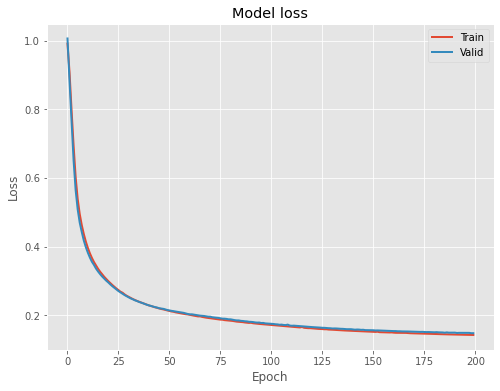

In [44]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

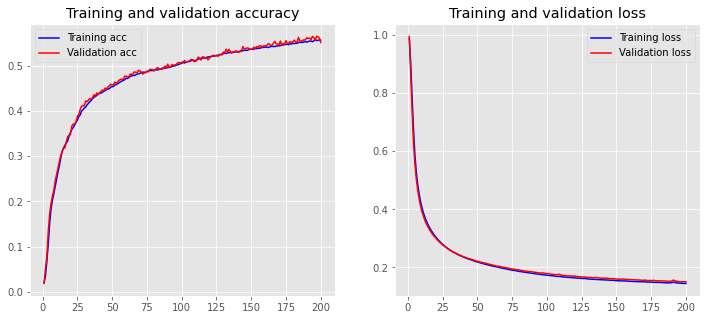

In [57]:
visual.plot_nn(lstm_autoencoder_history)

# Sanity check

Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

Expectation: the reconstruction error of 0 labeled data should be smaller than 1.

Caution: do not use this result for model evaluation. It may result into overfitting issues.

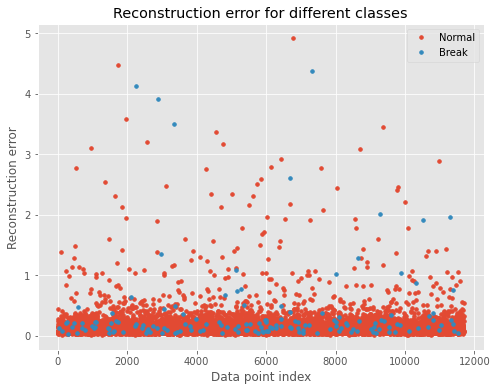

In [60]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(time_series.flatten(X_train_scaled) - time_series.flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

# Classification

In the following, we show how we can use an Autoencoder reconstruction error for the rare-event classification.

As mentioned before, if the reconstruction error is high, we will classify it as a sheet-break. We will need to determine the threshold for this.

We will use the validation set to identify the threshold.

# Predictions using the Autoencoder

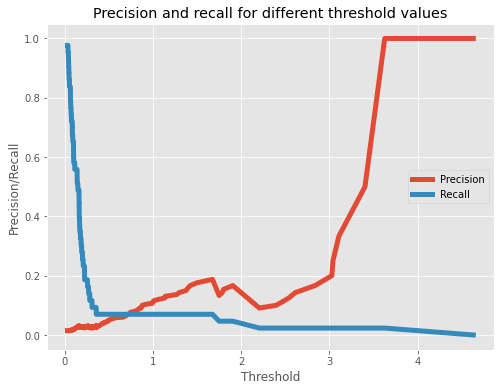

In [61]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(time_series.flatten(X_valid_scaled) - time_series.flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

We should not estimate the classification threshold from the test data. It will result in overfitting.

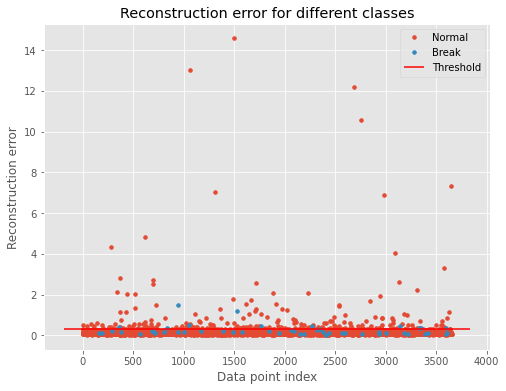

In [75]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(time_series.flatten(X_test_scaled) - time_series.flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In Figure 4, the orange and blue dot above the threshold line represents the True Positive and False Positive, respectively. As we can see, we have good number of false positives. To have a better look, we can see a confusion matrix.

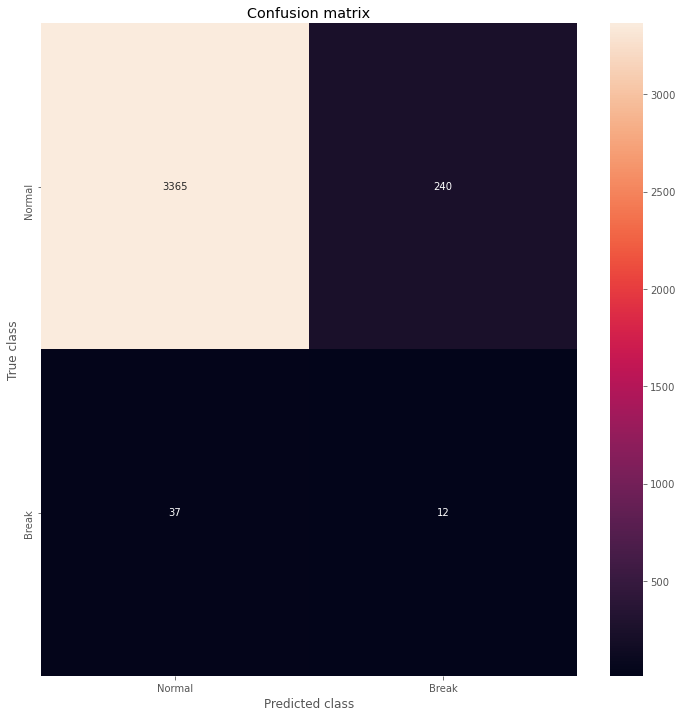

In [65]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We could predict 8 out of 41 breaks instances. Note that these instances include 2 or 4 minute ahead predictions. This is around 20%, which is a good recall rate for the paper industry. The False Positive Rate is around 6%. This is not ideal but not terrible for a mill.

Still, this model can be further improved to increase the recall rate with smaller False Positive Rate. We will look at the AUC below and then talk about the next approach for improvement.

# ROC curve and AUC

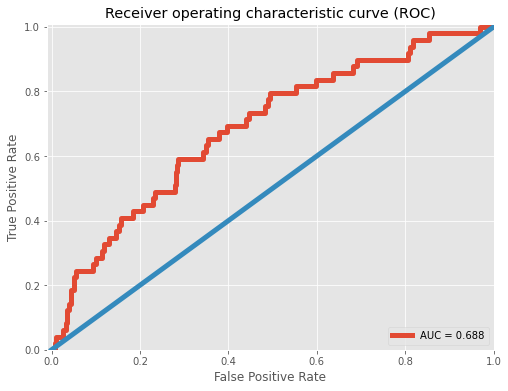

In [74]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

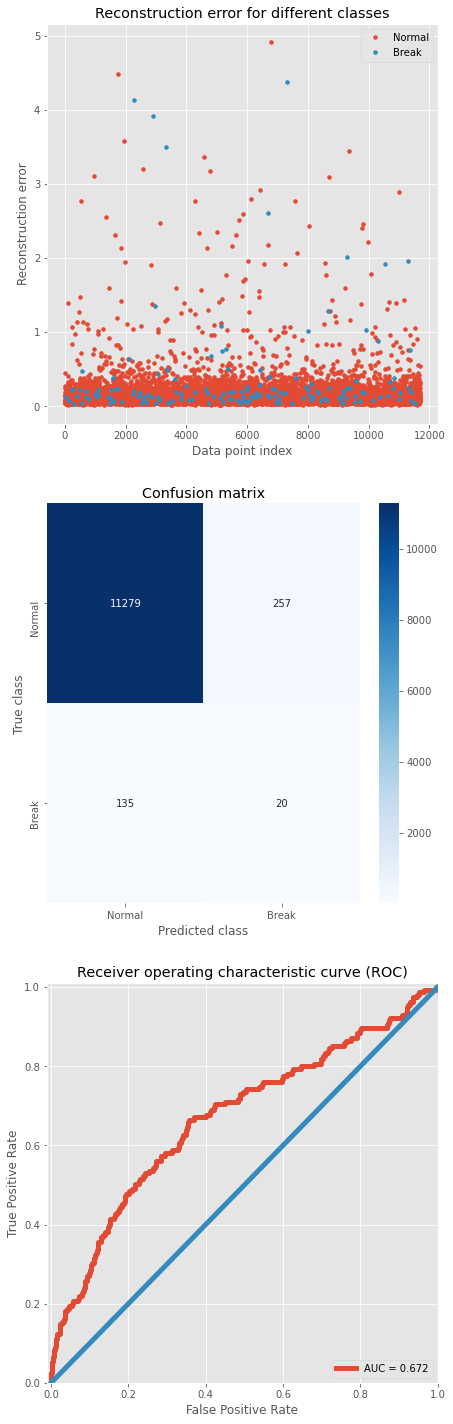

In [82]:
time_series.sanity_conf_matrix(lstm_autoencoder,X_train_scaled,y_train,'train',thresh=0.5,label=["Normal","Break"])